# Config

In [1]:
processed_set_folder_path = '/content/drive/MyDrive/mimic-iii-clinicalnote-v4.1/processed_set'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the data and packages

In [45]:
import pandas as pd
import numpy as np
import torch
import pickle
import os
import string
import nltk
from tqdm import tqdm
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.metrics import roc_auc_score
import ast
# Set the Seaborn style
sns.set(style="whitegrid")

## Load structured data

In [4]:
X_train_raw = pd.read_csv(os.path.join(processed_set_folder_path, 'X_train_raw.csv'))
X_test_raw = pd.read_csv(os.path.join(processed_set_folder_path, 'X_test_raw.csv'))
X_val_raw = pd.read_csv(os.path.join(processed_set_folder_path, 'X_val_raw.csv'))

## Load TF-IDF embedding data

In [46]:
X_train_tfidf = pd.read_csv(os.path.join(processed_set_folder_path, 'X_train_tfidf.csv'))
X_test_tfidf = pd.read_csv(os.path.join(processed_set_folder_path, 'X_test_tfidf.csv'))
X_val_tfidf = pd.read_csv(os.path.join(processed_set_folder_path, 'X_val_tfidf.csv'))

# Load X_train_tfidf
with open(os.path.join(processed_set_folder_path, 'X_train_tfidf.pkl'), 'rb') as file:
    X_train_tfidf_pkl = pickle.load(file)

# Load X_test_tfidf
with open(os.path.join(processed_set_folder_path, 'X_test_tfidf.pkl'), 'rb') as file:
    X_test_tfidf_pkl = pickle.load(file)

# Load X_val_tfidf
with open(os.path.join(processed_set_folder_path, 'X_val_tfidf.pkl'), 'rb') as file:
    X_val_tfidf_pkl = pickle.load(file)


In [49]:
X_train_tfidf_pkl

,icustay_id,slice_start,tfidf_dense
0,200006,2159-09-03 11:28:14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,200006,2159-09-03 13:28:14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,200006,2159-09-03 15:28:14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,200006,2159-09-03 17:28:14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2487702556589..."
4,200006,2159-09-03 19:28:14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
248791,299995,2116-03-05 07:44:39,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
248792,299995,2116-03-05 09:44:39,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
248793,299995,2116-03-05 11:44:39,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
248794,299995,2116-03-05 13:44:39,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
# X_train_bert = pd.read_csv(os.path.join(processed_set_folder_path, 'X_train_bert.csv'))
# X_test_bert = pd.read_csv(os.path.join(processed_set_folder_path, 'X_test_bert.csv'))
# X_val_bert = pd.read_csv(os.path.join(processed_set_folder_path, 'X_val_bert.csv'))

X_train_biobert = pd.read_csv(os.path.join(processed_set_folder_path, 'X_train_biobert.csv'))
X_test_biobert = pd.read_csv(os.path.join(processed_set_folder_path, 'X_test_biobert.csv'))
X_val_biobert = pd.read_csv(os.path.join(processed_set_folder_path, 'X_val_biobert.csv'))

# X_train_raw = pd.read_csv(os.path.join(processed_set_folder_path, 'X_train_clinicalbert.csv'))
# X_test_raw = pd.read_csv(os.path.join(processed_set_folder_path, 'X_test_clinicalbert.csv'))
# X_val_raw = pd.read_csv(os.path.join(processed_set_folder_path, 'X_val_clinicalbert.csv'))

y_train_id = pd.read_csv(os.path.join(processed_set_folder_path, 'y_train_id.csv'))
y_test_id = pd.read_csv(os.path.join(processed_set_folder_path, 'y_test_id.csv'))
y_val_id = pd.read_csv(os.path.join(processed_set_folder_path, 'y_val_id.csv'))

In [7]:
y_train_id = y_train_id.squeeze()
y_test_id = y_test_id.squeeze()
y_val_id = y_val_id.squeeze()

# Balance training set

In [8]:
y_train_id

0        1
1        1
2        1
3        1
4        1
        ..
20728    0
20729    1
20730    0
20731    1
20732    0
Name: AKI_Label, Length: 20733, dtype: int64

In [9]:
X_train_id = X_train_raw.drop_duplicates(subset=['icustay_id'])['icustay_id']

# Create a DataFrame from X_train_id
X_train_id_df = pd.DataFrame(X_train_id).reset_index(drop=True)

# Create a DataFrame from y_train_id
y_train_id_df = pd.DataFrame(y_train_id).reset_index(drop=True)

# Combine the two DataFrames
combined_df = pd.concat([X_train_id_df, y_train_id_df], axis=1)

# Rename columns if necessary
combined_df.columns = ['icustay_id', 'AKI_Label']

combined_df


,icustay_id,AKI_Label
0,200006,1
1,200009,1
2,200014,1
3,200025,1
4,200028,1
...,...,...
20728,299981,0
20729,299984,1
20730,299986,0
20731,299988,1


In [10]:
import pandas as pd

def balance_classes(df, label_column):
    """
    Balance the classes in the dataframe by undersampling the majority class.

    Args:
    df (pd.DataFrame): DataFrame to be balanced.
    label_column (str): Name of the column containing class labels.

    Returns:
    pd.DataFrame: Balanced DataFrame.
    """
    # Count the instances of each class and find the minimum count
    min_class_count = df[label_column].value_counts().min()

    # Sample from each class
    df_balanced = df.groupby(label_column).apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

    return df_balanced.sort_values(by=['icustay_id'])

# Usage Example
balanced_df = balance_classes(combined_df, 'AKI_Label')

# Verify the balance
print(balanced_df['AKI_Label'].value_counts())


1    10083
0    10083
Name: AKI_Label, dtype: int64


In [11]:
balanced_df

,icustay_id,AKI_Label
13415,200006,1
11686,200009,1
13255,200014,1
10911,200025,1
14819,200028,1
...,...,...
7949,299981,0
19066,299984,1
8861,299986,0
18774,299988,1


In [12]:
# Filter X_train_raw
X_train_raw = X_train_raw[X_train_raw['icustay_id'].isin(balanced_df['icustay_id'])]
y_train_id = balanced_df['AKI_Label']
X_train_raw.drop_duplicates(subset=['icustay_id'])

,icustay_id,slice_start,avg_pCO2,avg_Glucose,avg_Platelet_Count,avg_Potassium,avg_Calculated_total_CO2,avg_Urea_nitrogen,avg_Respiratory_rate,avg_Heartrate,avg_Arterial_blood_pressure_mean,avg_Arterial_blood_pressure_systolic,avg_Central_venous_pressure,avg_Arterial_blood_pressure_diastolic,avg_Tidal_volume_obs,avg_Temp_C,avg_Height_cm,processed_text
0,200006,2159-09-03 11:28:14,-0.003207,0.053683,-0.099660,-1.073710,-0.054551,-0.390230,0.003611,0.002630,0.005481,0.004993,-0.008160,-0.000732,-0.010367,0.025811,0.000348,missing
12,200009,2189-11-30 10:34:32,-0.211054,-0.793482,-0.334119,-0.312694,1.011681,-0.290212,0.003611,0.002630,0.005481,0.004993,-0.008160,-0.000732,-0.010367,0.025811,0.000348,missing
24,200014,2105-02-16 23:16:48,-1.493124,-0.486668,-0.822860,0.258068,-0.883070,0.276558,0.003611,0.002630,0.005481,0.004993,-0.008160,-0.000732,-0.010367,0.025811,0.000348,missing
36,200025,2113-08-25 09:29:12,0.429981,-0.153555,-0.741025,1.684972,0.064305,-0.156854,0.003611,0.002630,0.005481,0.004993,-0.008160,-0.000732,-0.010367,0.025811,0.000348,missing
48,200028,2133-10-29 17:13:50,0.358755,2.940885,-1.250224,-0.788329,-1.830445,-0.390230,1.421875,-1.066283,-1.538683,-0.032210,-0.413456,-0.137936,-0.537074,-0.496987,0.000348,21331029 548 pm chest portable ap clip clip nu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248736,299981,2168-08-04 10:58:20,-0.211054,-0.390241,-0.077246,-1.073710,-0.206373,-0.456909,0.003611,0.002630,0.005481,0.004993,-0.008160,-0.000732,-0.010367,0.025811,0.000348,216884 1227 pm chest port line placement clip ...
248748,299984,2185-09-13 11:01:26,-0.211054,0.118194,-0.120437,-0.455384,-0.544722,0.009843,0.003611,0.002630,0.005481,0.004993,-0.008160,-0.000732,-0.010367,0.025811,0.000348,missing
248760,299986,2116-12-17 18:29:21,-0.003207,1.143830,-0.959253,-0.883456,-0.054551,-0.590266,0.003611,0.002630,0.005481,0.004993,-0.008160,-0.000732,-0.010367,0.025811,0.000348,missing
248772,299988,2190-02-02 08:14:45,0.928564,0.188323,-0.495517,-0.312694,-0.883070,-0.656945,0.003611,0.002630,0.005481,0.004993,-0.008160,-0.000732,-0.010367,0.025811,0.000348,missing


In [13]:
y_train_id

13415    1
11686    1
13255    1
10911    1
14819    1
        ..
7949     0
19066    1
8861     0
18774    1
416      0
Name: AKI_Label, Length: 20166, dtype: int64

# Define LSTM model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Define model architecture
def create_model(sequence_length, num_features):
    input_layer = Input(shape=(sequence_length, num_features))
    lstm_layer = LSTM(100, return_sequences=True)(input_layer)
    lstm_layer = LSTM(50)(lstm_layer)
    output_layer = Dense(1, activation='sigmoid')(lstm_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
from tensorflow.keras.layers import Dropout

def create_model_with_dropout(sequence_length, num_features):
    input_layer = Input(shape=(sequence_length, num_features))
    lstm_layer = LSTM(100, return_sequences=True)(input_layer)
    dropout_layer1 = Dropout(0.2)(lstm_layer)  # Adding dropout
    lstm_layer2 = LSTM(50)(dropout_layer1)
    dropout_layer2 = Dropout(0.2)(lstm_layer2)  # Adding dropout
    output_layer = Dense(1, activation='sigmoid')(dropout_layer2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def create_model_v2(sequence_length, num_features):
    input_layer = Input(shape=(sequence_length, num_features))
    lstm_layer = LSTM(100, return_sequences=True)(input_layer)
    dropout_1 = Dropout(0.2)(lstm_layer)
    lstm_layer_2 = LSTM(50)(dropout_1)
    dropout_2 = Dropout(0.2)(lstm_layer_2)
    output_layer = Dense(1, activation='sigmoid')(dropout_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Structured data

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def prepare_structured_sequences(df, columns_to_drop, sequence_length):
    """
    Prepare padded sequences from a structured DataFrame.

    Args:
    df (pd.DataFrame): The raw DataFrame.
    columns_to_drop (list): List of column names to be dropped from the DataFrame.
    sequence_length (int): The maximum length for padding the sequences.

    Returns:
    np.array: An array of padded sequences.
    """
    # Drop specified columns
    df_structured = df.drop(columns_to_drop, axis=1)

    # Group by 'icustay_id' (assumed to be the first column)
    df_grouped = df_structured.groupby(df_structured.columns[0])

    # Extract sequences for each group
    sequences = []
    for _, group in tqdm(df_grouped, total=df_grouped.ngroups, desc="Processing Groups"):
        # Extract features, excluding the first column ('icustay_id')
        features = group.iloc[:, 1:].values
        sequences.append(features)

    # Convert the list of sequences to a numpy array
    sequences_array = np.array(sequences, dtype=object)

    # Pad sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences_array, maxlen=sequence_length, padding='post', dtype='float32')

    return padded_sequences

# Usage Example
columns_to_drop = ['slice_start', 'processed_text']
sequence_length = 12
X_train_padded = prepare_structured_sequences(X_train_raw, columns_to_drop, sequence_length)
X_test_padded = prepare_structured_sequences(X_test_raw, columns_to_drop, sequence_length)
X_val_padded = prepare_structured_sequences(X_val_raw, columns_to_drop, sequence_length)


Processing Groups: 100%|██████████| 6912/6912 [00:02<00:00, 2307.43it/s]


In [18]:
np.shape(X_train_padded)

(20166, 12, 15)

In [19]:
type(X_train_padded)

numpy.ndarray

In [20]:
X_train_padded[0][0]

array([-3.2070437e-03,  5.3683337e-02, -9.9660486e-02, -1.0737096e+00,
       -5.4550819e-02, -3.9022985e-01,  3.6111937e-03,  2.6304980e-03,
        5.4809400e-03,  4.9933945e-03, -8.1598358e-03, -7.3171104e-04,
       -1.0366749e-02,  2.5810802e-02,  3.4790748e-04], dtype=float32)

In [21]:
sequence_length = 12
model_structured = create_model_v2(sequence_length, X_train_padded.shape[2])
model_structured.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 15)]          0         
                                                                 
 lstm (LSTM)                 (None, 12, 100)           46400     
                                                                 
 dropout (Dropout)           (None, 12, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 76651 (299.42 KB)
Trainable params: 76651 (299.

## LSTM training session

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

history = model_structured.fit(X_train_padded, y_train_id, validation_data=(X_val_padded, y_val_id), epochs=100, batch_size=32, callbacks=[early_stopping])
loss, accuracy = model_structured.evaluate(X_test_padded, y_test_id)

Epoch 1/100
631/631 [==============================] - 21s 19ms/step - loss: 0.6569 - accuracy: 0.6117 - val_loss: 0.6505 - val_accuracy: 0.6259
Epoch 2/100
631/631 [==============================] - 11s 17ms/step - loss: 0.6367 - accuracy: 0.6459 - val_loss: 0.6402 - val_accuracy: 0.6447
Epoch 3/100
631/631 [==============================] - 12s 19ms/step - loss: 0.6249 - accuracy: 0.6574 - val_loss: 0.6515 - val_accuracy: 0.6451
Epoch 4/100
631/631 [==============================] - 15s 25ms/step - loss: 0.6192 - accuracy: 0.6650 - val_loss: 0.6454 - val_accuracy: 0.6492
Epoch 5/100
216/216 [==============================] - 2s 9ms/step - loss: 0.6438 - accuracy: 0.6324


## LSTM evaluation

216/216 [==============================] - 3s 8ms/step
Optimal Threshold: 0.36161836981773376
AUROC: 0.6851380019342093
Sensitivity (Recall or True Positive Rate): 0.7106899615042938
Specificity (True Negative Rate): 0.5801980198019802


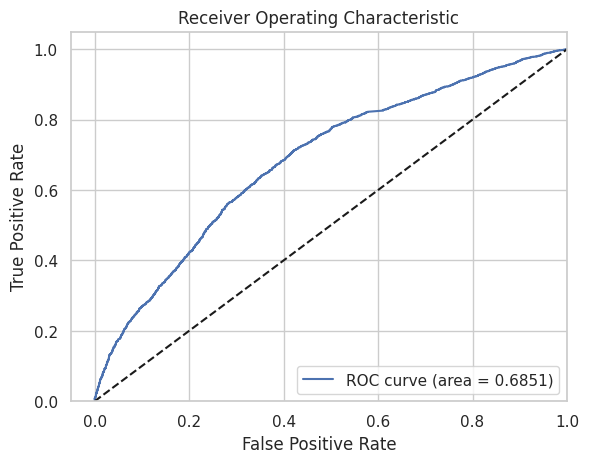

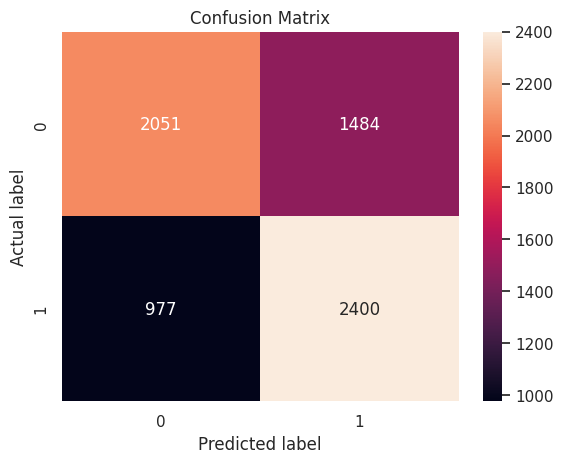

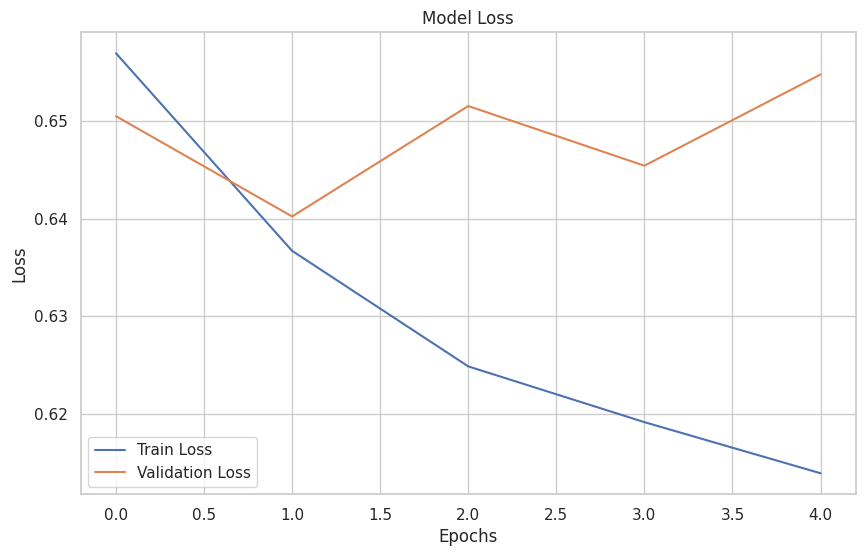

In [23]:
# Evaluate the model on the test set
y_pred = model_structured.predict(X_test_padded)
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_id, y_pred)

# Calculate the Youden Index
youden_index = tpr - fpr

# Find the optimal threshold (the one for which Youden's J statistic is maximized)
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Now use the optimal threshold to convert probabilities into binary decisions
y_pred_optimal = (y_pred > optimal_threshold).astype(int)

# Calculate AUROC
auroc = roc_auc_score(y_test_id, y_pred)
print(f"AUROC: {auroc}")
cm = confusion_matrix(y_test_id, y_pred_optimal)
# Assuming cm is your confusion matrix
TN, FP, FN, TP = cm.ravel()

# Calculate Sensitivity and Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity (Recall or True Positive Rate): {sensitivity}")
print(f"Specificity (True Negative Rate): {specificity}")
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_id, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


# TF-IDF

In [55]:
# Filter X_train_raw
X_train_tfidf_pkl = X_train_tfidf_pkl[X_train_tfidf_pkl['icustay_id'].isin(balanced_df['icustay_id'])]
y_train_id = balanced_df['AKI_Label']

In [56]:
type(X_train_tfidf_pkl['tfidf_dense'][0])

list

In [57]:
def prepare_unstructured_sequences(df, columns_to_select, sequence_length):
    """
    Prepare padded sequences from a structured DataFrame.

    Args:
    df (pd.DataFrame): The raw DataFrame.
    columns_to_drop (list): List of column names to be dropped from the DataFrame.
    sequence_length (int): The maximum length for padding the sequences.

    Returns:
    np.array: An array of padded sequences.
    """
    # Drop specified columns
    df_structured = df[columns_to_select]

    # Group by 'icustay_id' (assumed to be the first column)
    df_grouped = df_structured.groupby('icustay_id').agg(lambda x: x.tolist())

    # Extract sequences for each group
    sequences = []
    for _, row in df_grouped.iterrows():
        # sequence = [ast.literal_eval(vector) for vector in row['tfidf_dense']]
        # sequences.append(sequence)
        sequences.append(row['tfidf_dense'])

    # Pad sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')

    return padded_sequences

# Usage Example
columns_to_select = ['icustay_id', 'tfidf_dense']
sequence_length = 12
X_train_tfidf_padded = prepare_unstructured_sequences(X_train_tfidf_pkl, columns_to_select, sequence_length)
X_test_tfidf_padded = prepare_unstructured_sequences(X_test_tfidf_pkl, columns_to_select, sequence_length)
X_val_tfidf_padded = prepare_unstructured_sequences(X_val_tfidf_pkl, columns_to_select, sequence_length)

In [52]:
np.shape(X_train_tfidf_padded)

(20733, 12, 20)

## LSTM training session

In [58]:
model_tfidf = create_model_v2(X_train_tfidf_padded.shape[1], X_train_tfidf_padded.shape[2])
model_tfidf.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 12, 20)]          0         
                                                                 
 lstm_10 (LSTM)              (None, 12, 100)           48400     
                                                                 
 dropout_10 (Dropout)        (None, 12, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 78651 (307.23 KB)
Trainable params: 78651 (30

In [59]:
history = model_tfidf.fit(X_train_tfidf_padded, y_train_id, validation_data=(X_val_tfidf_padded, y_val_id), epochs=100, batch_size=32, callbacks=[early_stopping])
loss, accuracy = model_tfidf.evaluate(X_test_tfidf_padded, y_test_id)

Epoch 1/100
631/631 [==============================] - 15s 19ms/step - loss: 0.5339 - accuracy: 0.7137 - val_loss: 0.5005 - val_accuracy: 0.7367
Epoch 2/100
631/631 [==============================] - 11s 17ms/step - loss: 0.4892 - accuracy: 0.7380 - val_loss: 0.4879 - val_accuracy: 0.7461
Epoch 3/100
631/631 [==============================] - 11s 17ms/step - loss: 0.4818 - accuracy: 0.7442 - val_loss: 0.4809 - val_accuracy: 0.7490
Epoch 4/100
631/631 [==============================] - 11s 17ms/step - loss: 0.4773 - accuracy: 0.7442 - val_loss: 0.4784 - val_accuracy: 0.7500
Epoch 5/100
631/631 [==============================] - 11s 17ms/step - loss: 0.4761 - accuracy: 0.7463 - val_loss: 0.4813 - val_accuracy: 0.7499
Epoch 6/100
631/631 [==============================] - 11s 17ms/step - loss: 0.4743 - accuracy: 0.7487 - val_loss: 0.4759 - val_accuracy: 0.7510
Epoch 7/100
631/631 [==============================] - 11s 17ms/step - loss: 0.4723 - accuracy: 0.7495 - val_loss: 0.4756 - val_ac

## LSTM evaluation

216/216 [==============================] - 2s 6ms/step
Optimal Threshold: 0.5298724174499512
AUROC: 0.8097009933659722
Sensitivity (Recall or True Positive Rate): 0.5368670417530352
Specificity (True Negative Rate): 0.9507779349363508


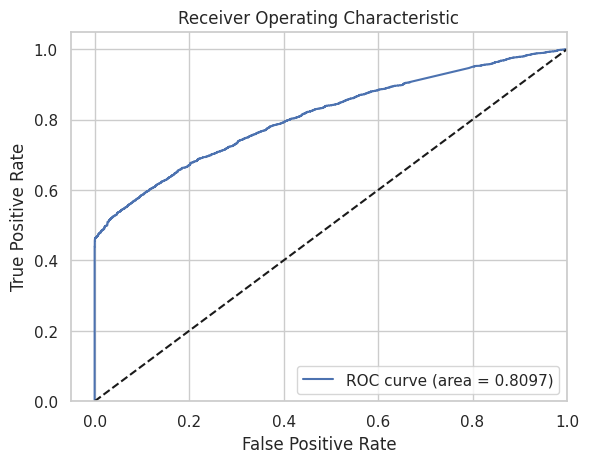

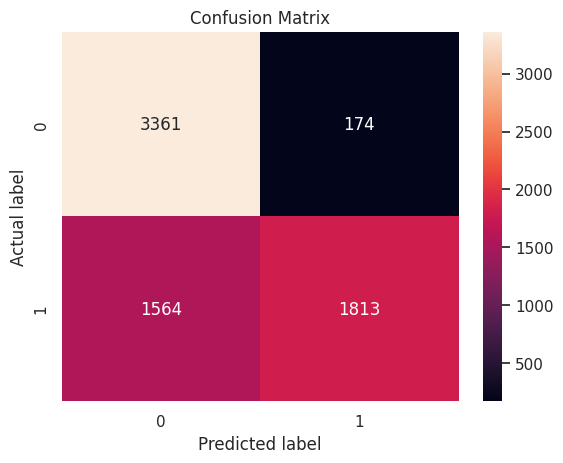

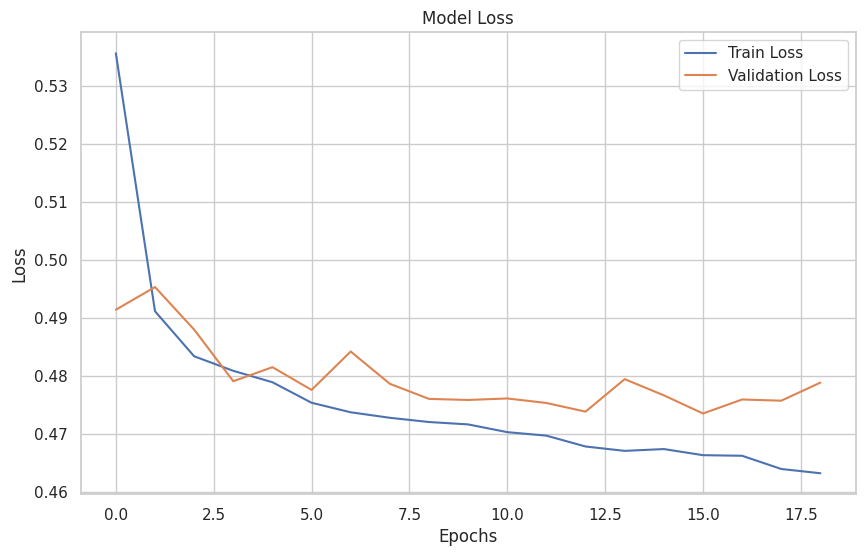

In [30]:
# Evaluate the model on the test set
y_pred = model_tfidf.predict(X_test_tfidf_padded)
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_id, y_pred)

# Calculate the Youden Index
youden_index = tpr - fpr

# Find the optimal threshold (the one for which Youden's J statistic is maximized)
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Now use the optimal threshold to convert probabilities into binary decisions
y_pred_optimal = (y_pred > optimal_threshold).astype(int)

# Calculate AUROC
auroc = roc_auc_score(y_test_id, y_pred)
print(f"AUROC: {auroc}")
cm = confusion_matrix(y_test_id, y_pred_optimal)
# Assuming cm is your confusion matrix
TN, FP, FN, TP = cm.ravel()

# Calculate Sensitivity and Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity (Recall or True Positive Rate): {sensitivity}")
print(f"Specificity (True Negative Rate): {specificity}")
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_id, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()



#

# BERT

In [31]:
# Balance X_train_bert
# X_train_bert = X_train_bert[X_train_bert['icustay_id'].isin(balanced_df['icustay_id'])]
# y_train_id = balanced_df['AKI_Label']

In [32]:
# def prepare_unstructured_sequences(df, columns_to_select, sequence_length):
#     """
#     Prepare padded sequences from a structured DataFrame.

#     Args:
#     df (pd.DataFrame): The raw DataFrame.
#     columns_to_drop (list): List of column names to be dropped from the DataFrame.
#     sequence_length (int): The maximum length for padding the sequences.

#     Returns:
#     np.array: An array of padded sequences.
#     """
#     # Drop specified columns
#     df_structured = df[columns_to_select]

#     # Group by 'icustay_id' (assumed to be the first column)
#     df_grouped = df_structured.groupby('icustay_id').agg(lambda x: x.tolist())

#     # Extract sequences for each group
#     sequences = []
#     for _, row in tqdm(df_grouped.iterrows(), total=df_grouped.shape[0], desc="Processing Groups"):
#         sequence = [ast.literal_eval(vector) for vector in row[columns_to_select[1]]]
#         sequences.append(sequence)

#     # Pad sequences to ensure uniform length
#     padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')

#     return padded_sequences

# # Usage Example
# columns_to_select = ['icustay_id', 'tfidf_dense']
# sequence_length = 12
# X_train_tfidf_padded = prepare_unstructured_sequences(X_train_bert, columns_to_select, sequence_length)
# X_test_tfidf_padded = prepare_unstructured_sequences(X_train_bert, columns_to_select, sequence_length)
# X_val_tfidf_padded = prepare_unstructured_sequences(X_train_bert, columns_to_select, sequence_length)

# BioBERT

In [33]:
X_train_biobert['bio_bert_embeddings'][0]

'[0.6558036804199219, 0.1661715805530548, -0.24504071474075317, -0.36754465103149414, 0.11845558136701584, -0.0924755334854126, 0.2879621684551239, -0.19655555486679077, 0.4180290699005127, -0.501286506652832, -0.3263535499572754, 0.5424978733062744, -0.2217157781124115, -0.7159353494644165, -0.6788281798362732, 0.35478314757347107, 0.5218647718429565, 0.11238862574100494, 0.32873618602752686, -0.3117469847202301, -0.028405746445059776, -0.1684931218624115, 0.8283184766769409, -0.22008457779884338, -0.11088605225086212, 0.112495556473732, 1.1761245727539062, -0.04900228977203369, -0.4283590018749237, 0.7267124056816101, -0.056693416088819504, -0.10932286083698273, -0.34141695499420166, -0.11259293556213379, -0.29886338114738464, -0.0014165739994496107, 0.01464495062828064, -0.08437758684158325, 0.014884020201861858, 0.6225106120109558, -0.043325275182724, -0.23211686313152313, 1.0461064577102661, -0.11577483266592026, 0.5342667102813721, -0.1930447220802307, 0.20437610149383545, 0.5869

In [34]:
type(X_train_biobert['bio_bert_embeddings'][0])

str

In [35]:
# Balance X_train_biobert
X_train_biobert = X_train_biobert[X_train_biobert['icustay_id'].isin(balanced_df['icustay_id'])]
y_train_id = balanced_df['AKI_Label']

In [36]:
def prepare_unstructured_sequences(df, columns_to_select, sequence_length):
    """
    Prepare padded sequences from a structured DataFrame.

    Args:
    df (pd.DataFrame): The raw DataFrame.
    columns_to_drop (list): List of column names to be dropped from the DataFrame.
    sequence_length (int): The maximum length for padding the sequences.

    Returns:
    np.array: An array of padded sequences.
    """
    # Drop specified columns
    df_structured = df[columns_to_select]

    # Group by 'icustay_id' (assumed to be the first column)
    df_grouped = df_structured.groupby('icustay_id').agg(lambda x: x.tolist())

    # Extract sequences for each group
    sequences = []
    for _, row in tqdm(df_grouped.iterrows(), total=df_grouped.shape[0], desc="Processing Groups"):
        sequence = [ast.literal_eval(vector) for vector in row[columns_to_select[1]]]
        sequences.append(sequence)
        # sequences.append(row[columns_to_select[1]])

    # Pad sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')

    return padded_sequences

# Usage Example
columns_to_select = ['icustay_id', 'bio_bert_embeddings']
sequence_length = 12
X_train_biobert_padded = prepare_unstructured_sequences(X_train_biobert, columns_to_select, sequence_length)
X_test_biobert_padded = prepare_unstructured_sequences(X_test_biobert, columns_to_select, sequence_length)
X_val_biobert_padded = prepare_unstructured_sequences(X_val_biobert, columns_to_select, sequence_length)

Processing Groups: 100%|██████████| 6912/6912 [05:31<00:00, 20.83it/s]


## LSTM training session

In [38]:
model_biobert = create_model_v2(X_train_biobert_padded.shape[1], X_train_biobert_padded.shape[2])
model_biobert.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 768)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 12, 100)           347600    
                                                                 
 dropout_4 (Dropout)         (None, 12, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 377851 (1.44 MB)
Trainable params: 377851 (1.

In [39]:
history = model_biobert.fit(X_train_biobert_padded, y_train_id, validation_data=(X_val_biobert_padded, y_val_id), epochs=100, batch_size=32, callbacks=[early_stopping])
loss, accuracy = model_biobert.evaluate(X_test_biobert_padded, y_test_id)

Epoch 1/100
631/631 [==============================] - 20s 26ms/step - loss: 0.4924 - accuracy: 0.7339 - val_loss: 0.4776 - val_accuracy: 0.7477
Epoch 2/100
631/631 [==============================] - 16s 25ms/step - loss: 0.4702 - accuracy: 0.7490 - val_loss: 0.4689 - val_accuracy: 0.7555
Epoch 3/100
631/631 [==============================] - 17s 27ms/step - loss: 0.4614 - accuracy: 0.7595 - val_loss: 0.4573 - val_accuracy: 0.7642
Epoch 4/100
631/631 [==============================] - 15s 24ms/step - loss: 0.4574 - accuracy: 0.7636 - val_loss: 0.4585 - val_accuracy: 0.7603
Epoch 5/100
631/631 [==============================] - 16s 25ms/step - loss: 0.4558 - accuracy: 0.7615 - val_loss: 0.4557 - val_accuracy: 0.7653
Epoch 6/100
631/631 [==============================] - 15s 24ms/step - loss: 0.4540 - accuracy: 0.7646 - val_loss: 0.4541 - val_accuracy: 0.7665
Epoch 7/100
631/631 [==============================] - 15s 24ms/step - loss: 0.4526 - accuracy: 0.7624 - val_loss: 0.4613 - val_ac

## LSTM evaluation

216/216 [==============================] - 4s 13ms/step
Optimal Threshold: 0.49964919686317444
AUROC: 0.8280247568730814
Sensitivity (Recall or True Positive Rate): 0.6185963873260291
Specificity (True Negative Rate): 0.9114568599717114


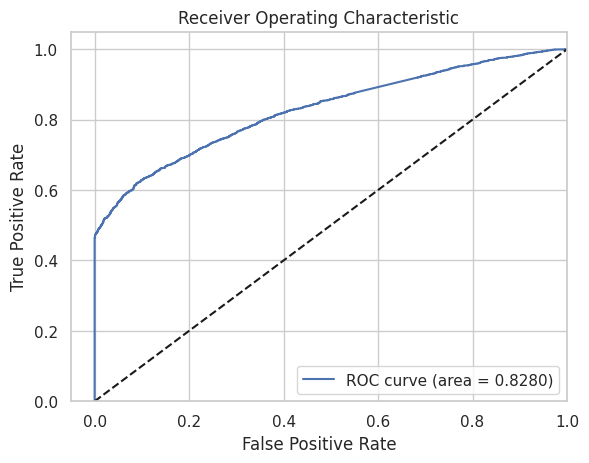

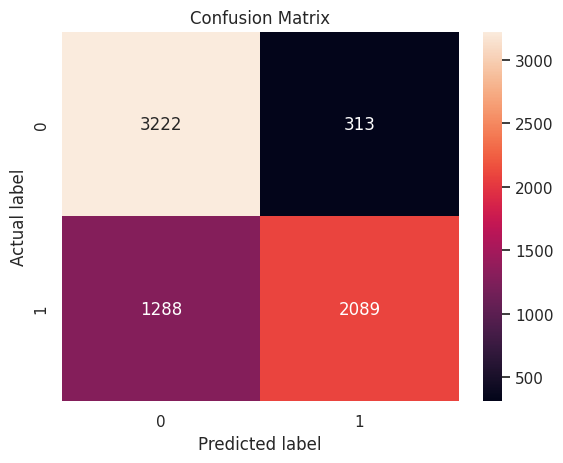

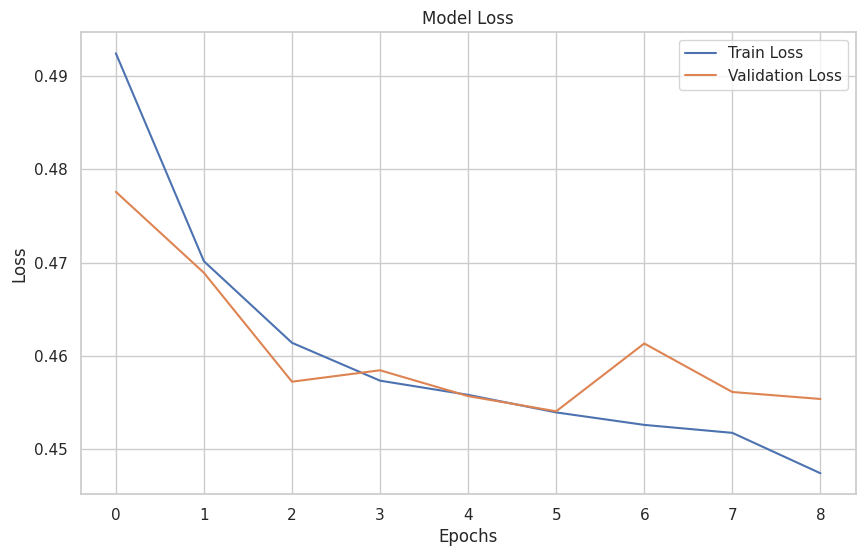

In [40]:
# Evaluate the model on the test set
y_pred = model_biobert.predict(X_test_biobert_padded)
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_id, y_pred)

# Calculate the Youden Index
youden_index = tpr - fpr

# Find the optimal threshold (the one for which Youden's J statistic is maximized)
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Now use the optimal threshold to convert probabilities into binary decisions
y_pred_optimal = (y_pred > optimal_threshold).astype(int)

# Calculate AUROC
auroc = roc_auc_score(y_test_id, y_pred)
print(f"AUROC: {auroc}")
cm = confusion_matrix(y_test_id, y_pred_optimal)
# Assuming cm is your confusion matrix
TN, FP, FN, TP = cm.ravel()

# Calculate Sensitivity and Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity (Recall or True Positive Rate): {sensitivity}")
print(f"Specificity (True Negative Rate): {specificity}")
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_id, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()



# ClinicalBERT